In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from rank_bm25 import BM25Okapi
from nltk.util import ngrams
import re
import string
from tqdm import tqdm
import os 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter



# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/oceanspiess/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oceanspiess/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oceanspiess/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/oceanspiess/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
data_folder_path = os.path.join('avis_trad')

dfs = []
for file_name in os.listdir(data_folder_path):
    path = os.path.join(data_folder_path, file_name)
    new_df = pd.read_excel(path)
    dfs.append(new_df)

df = pd.concat(dfs, ignore_index=True)

In [3]:
df[df['type'] == 'train'].head()

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
2000,5.0,claire-m-130353,"les prix au top, la facilité d'inscription et ...",Direct Assurance,auto,train,31/08/2021,01/08/2021,"top prices, ease of registration and clear ser...",NaN,NaN
2001,2.0,tontonlouis-90075,je n'ai pas les moyens d'attendre 3 à 4 semain...,Cegema Assurances,sante,train,30/05/2020,01/05/2020,I cannot afford to wait 3 to 4 weeks for reimb...,NaN,NaN
2002,1.0,fred78-132197,Je voulais assurer une Tesla Modèle 3 LR ...\n...,MACIF,auto,train,10/09/2021,01/09/2021,I wanted to ensure a Tesla Model 3 LR ...\nThe...,NaN,NaN
2003,1.0,sud-70690,"Je suis en arrêt de travail depuis nov 2017 ,a...",Cardif,credit,train,07/02/2019,01/02/2019,"I am on work stoppage since Nov 2017, assured ...",NaN,NaN
2004,1.0,fofi-80683,inadmissible... je leur ai réglé un trop perçu...,Harmonie Mutuelle,sante,train,04/11/2019,01/11/2019,Inadmissible ... I set them too perceived foll...,NaN,NaN


In [4]:
print(df.info())

print(f"\nNombre de lignes: {df.shape[0]}")
print(f"Nombre de colonnes: {df.shape[1]}")

print("\nRépartition des valeurs manquantes:")
print(df.isnull().sum())

print(f"\nNombre d'avis de type 'test': {len(df[df['type'] == 'test'])} \n")

print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34435 entries, 0 to 34434
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   note              24104 non-null  float64
 1   auteur            34434 non-null  object 
 2   avis              34435 non-null  object 
 3   assureur          34435 non-null  object 
 4   produit           34435 non-null  object 
 5   type              34435 non-null  object 
 6   date_publication  34435 non-null  object 
 7   date_exp          34435 non-null  object 
 8   avis_en           34433 non-null  object 
 9   avis_cor          435 non-null    object 
 10  avis_cor_en       431 non-null    object 
dtypes: float64(1), object(10)
memory usage: 2.9+ MB
None

Nombre de lignes: 34435
Nombre de colonnes: 11

Répartition des valeurs manquantes:
note                10331
auteur                  1
avis                    0
assureur                0
produit                 0
type   

In [5]:
# Drop specified columns
df = df.drop(['avis_cor', 'avis_cor_en', 'auteur', 'date_publication', 'date_exp', 'produit'], axis=1)

# Remove rows where avis_en is null
df = df.dropna(subset=['avis_en'])

# Reset index after dropping rows
df = df.reset_index(drop=True)


In [6]:
df.head()

,note,avis,assureur,type,avis_en
0,NaN,j'ai quitté mon ancien contrat d'assurance che...,Néoliane Santé,test,I left my former insurance contract at General...
1,NaN,j'ai souscrit à cette mutuelle l'année dernier...,Néoliane Santé,test,I subscribed to this mutual a year last year a...
2,NaN,"Impossible d'avoir le bon service , ils raccro...",Néoliane Santé,test,"Impossible to have the right service, they han..."
3,NaN,Génération est une mutuelle très chère pour un...,Génération,test,Generation is a very expensive mutual for a re...
4,NaN,je viens d apprendre que je suis radié... j ap...,Génération,test,I just learned that I am struck off ... I call...


In [7]:
print("\nNombre d'avis par assureur:")
print(df['assureur'].value_counts())


Nombre d'avis par assureur:
assureur
Direct Assurance        8503
L'olivier Assurance     6079
APRIL Moto              1475
GMF                     1472
Néoliane Santé          1217
MACIF                   1194
AMV                      996
Santiane                 953
AXA                      893
MAAF                     881
MAIF                     826
Allianz                  825
Pacifica                 776
Matmut                   677
MGP                      637
Active Assurances        566
Ag2r La Mondiale         518
Eurofil                  431
Harmonie Mutuelle        425
APRIL                    392
Cardif                   380
Mercer                   372
Zen'Up                   337
Cegema Assurances        312
Mgen                     305
Génération               292
Afer                     224
Crédit Mutuel            193
CNP Assurances           193
Eca Assurances           191
SwissLife                184
Mutuelle des Motards     180
Generali                 173
Assur

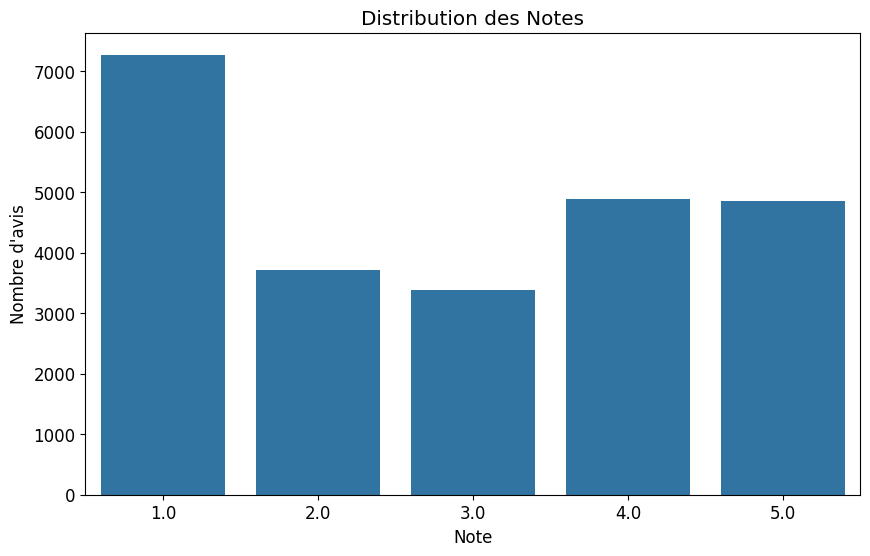

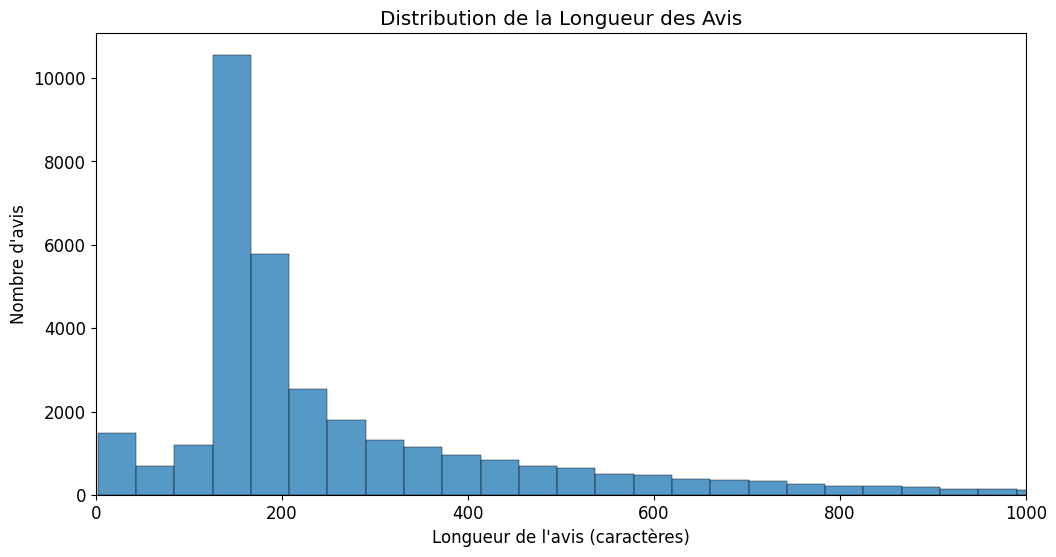

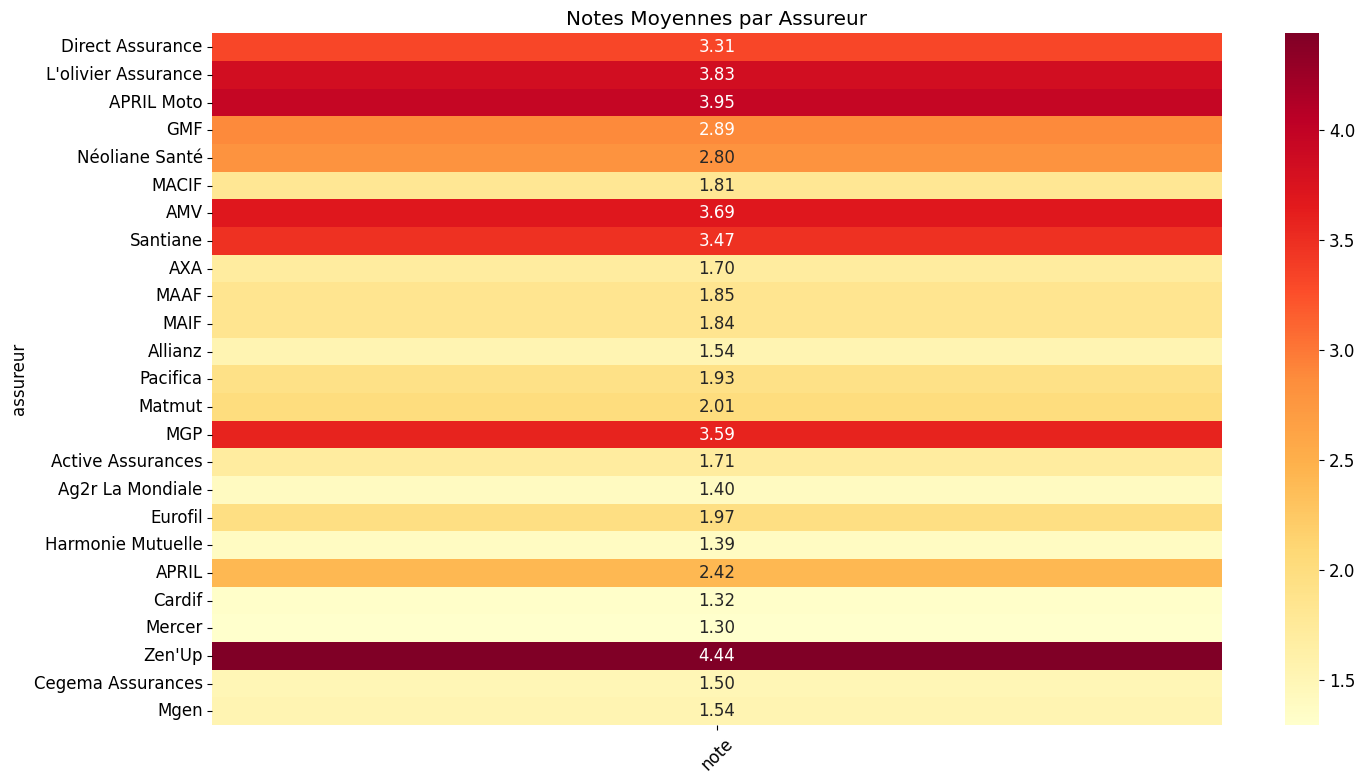

In [8]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# 1. Distribution des notes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='note')
plt.title('Distribution des Notes')
plt.xlabel('Note')
plt.ylabel('Nombre d\'avis')
plt.show()

# 4. Distribution de la longueur des avis
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x=df['avis_en'].str.len(), bins=200)
plt.title('Distribution de la Longueur des Avis')
plt.xlabel('Longueur de l\'avis (caractères)')
plt.ylabel('Nombre d\'avis')
plt.xlim(0, 1000)  # Limiter l'axe x pour une meilleure lisibilité
plt.show()

# 5. Heatmap des notes moyennes par assureur
plt.figure(figsize=(15, 8))
notes_moyennes = df.groupby('assureur')['note'].mean().to_frame()
# Filtrer pour n'avoir que les assureurs avec un nombre minimum d'avis
assureurs_frequents = df['assureur'].value_counts()[df['assureur'].value_counts() > 300].index
notes_moyennes = notes_moyennes.loc[assureurs_frequents]

sns.heatmap(notes_moyennes, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Notes Moyennes par Assureur')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# Fonction pour nettoyer le texte
def clean_text(text):
    # Convertir en minuscules
    text = text.lower()
    # Supprimer la ponctuation et les caractères spéciaux
    text = re.sub(r'[^\w\s]', ' ', text)
    # Supprimer les chiffres
    text = re.sub(r'\d+', '', text)
    # Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [10]:
# Nettoyer et tokenizer tous les textes en anglais
tokens_list = []
for text in df['avis_en']:
    # Nettoyage de base
    clean = clean_text(text)
    
    # Tokenization
    tokens = word_tokenize(clean)
    
    # Filtrer les stop words anglais
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Filtrer les tokens trop courts
    tokens = [token for token in tokens if len(token) > 2]
    
    # Filtrer les tokens non-alphabétiques 
    tokens = [token for token in tokens if token.isalpha()]
    
    tokens_list.extend(tokens)

In [11]:
# Fonction pour obtenir les n-grams les plus fréquents
def get_top_ngrams(texts, n, top_k=20):
    # Créer les n-grams
    n_grams = list(ngrams(tokens_list, n))
    # Compter les fréquences
    freq_dist = Counter(n_grams)
    # Retourner les top_k plus fréquents
    return freq_dist.most_common(top_k)

In [12]:
# Analyse des mots fréquents dans les avis en anglais
print("\nAnalyse des mots fréquents dans les avis en anglais")
print("-" * 50)

# 1. Mots uniques (unigrams)
print("\nTop 20 mots les plus fréquents:")
unigrams = get_top_ngrams(df['avis_en'], 1)
for gram, count in unigrams:
    print(f"{gram[0]}: {count}")

# 2. Bigrams
print("\nTop 20 paires de mots (bigrams) les plus fréquentes:")
bigrams = get_top_ngrams(df['avis_en'], 2)
for gram, count in bigrams:
    print(f"{gram[0]} {gram[1]}: {count}")

# 3. Trigrams
print("\nTop 20 triplets de mots (trigrams) les plus fréquents:")
trigrams = get_top_ngrams(df['avis_en'], 3)
for gram, count in trigrams:
    print(f"{gram[0]} {gram[1]} {gram[2]}: {count}")


Analyse des mots fréquents dans les avis en anglais
--------------------------------------------------

Top 20 mots les plus fréquents:
insurance: 18122
service: 11739
price: 11461
year: 9578
contract: 8818
satisfied: 8212
customer: 6515
month: 6141
good: 5445
time: 5291
vehicle: 4711
without: 4588
well: 4220
car: 4188
file: 3976
phone: 3937
recommend: 3913
take: 3800
since: 3752
day: 3721

Top 20 paires de mots (bigrams) les plus fréquentes:
satisfied service: 2586
customer service: 2423
direct insurance: 1826
satisfied price: 977
service price: 796
insurance company: 720
recommend insurance: 664
price suit: 647
car insurance: 613
take care: 609
third party: 572
non responsible: 563
insurance contract: 551
highly recommend: 548
attractive price: 539
olive tree: 532
green card: 521
home insurance: 491
value money: 487
life insurance: 476

Top 20 triplets de mots (trigrams) les plus fréquents:
satisfied service price: 590
mutual insurance company: 333
loading loading loading: 265
good 

In [13]:
from spellchecker import SpellChecker
from tqdm import tqdm

print("\nCorrection orthographique des avis en anglais")
print("-" * 50)

# Initialiser le correcteur orthographique
spell = SpellChecker()

def correct_spelling_fast(text):
    if not isinstance(text, str):
        return text
    
    # Diviser le texte en mots
    words = text.split()
    
    # Corriger uniquement les mots mal orthographiés
    corrected_words = []
    for word in words:
        # Vérifier uniquement les mots alphabétiques
        if word.isalpha():
            corrected = spell.correction(word)
            corrected_words.append(corrected if corrected else word)
        else:
            corrected_words.append(word)
    
    return ' '.join(corrected_words)

# Appliquer la correction orthographique avec une barre de progression
print("\nCorrection en cours...")
df['avis_cor_en'] = [correct_spelling_fast(text) for text in tqdm(df['avis_en'])]

# Afficher 5 exemples
print("\nExemples de textes corrigés:")
sample_indices = df.sample(n=5, random_state=42).index
for idx in sample_indices:
    print("\nOriginal:", df.loc[idx, 'avis_en'])
    print("Corrigé:", df.loc[idx, 'avis_cor_en'])


Correction orthographique des avis en anglais
--------------------------------------------------

Correction en cours...


  1%|          | 215/34433 [00:14<1:00:00,  9.50it/s]

In [22]:
# Analyse de la longueur des mots
word_lengths = [len(word) for word in tokens_list]

# Statistiques sur la longueur des mots
print("\nStatistiques sur la longueur des mots:")
print(f"Longueur moyenne: {np.mean(word_lengths):.2f}")
print(f"Longueur médiane: {np.median(word_lengths):.2f}")
print(f"Écart-type: {np.std(word_lengths):.2f}")
print(f"Longueur minimale: {min(word_lengths)}")
print(f"Longueur maximale: {max(word_lengths)}")

# Analyse des mots les plus longs et les plus courts
print("\nLes 5 mots les plus longs:")
all_words = tokens_list

# Trier les mots par longueur et prendre les 5 plus longs
longest_words = sorted(set(all_words), key=len, reverse=True)[:5]
for word in longest_words:
    print(f"{word}: {len(word)} caractères")



Statistiques sur la longueur des mots:
Longueur moyenne: 6.44
Longueur médiane: 6.00
Écart-type: 2.68
Longueur minimale: 3
Longueur maximale: 990

Les 5 mots les plus longs:
satisfaitaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaacccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

In [23]:
def analyze_word_lengths(text_series, max_length=25, tolerance=10):
    """
    Analyse et nettoie les mots trop longs
    max_length: longueur maximale acceptable pour un mot
    tolerance: nombre de caractères supplémentaires autorisés avant suppression
    """
    # Fonction pour traiter un texte
    def clean_long_words(text):
        if not isinstance(text, str):
            return text
        words = text.split()
        cleaned_words = []
        for word in words:
            # Enlever la ponctuation pour vérifier la vraie longueur du mot
            clean_word = re.sub(r'[^\w\s]', '', word)
            if len(clean_word) <= max_length + tolerance:
                cleaned_words.append(word)
            else:
                print(f"Mot supprimé (trop long): {word} ({len(clean_word)} caractères)")
        return ' '.join(cleaned_words)

    # Nettoyer les textes
    cleaned_series = text_series.apply(clean_long_words)
    
    # Analyse après nettoyage
    all_words_after = []
    for text in cleaned_series:
        if isinstance(text, str):
            words = re.findall(r'\b\w+\b', text.lower())
            all_words_after.extend(words)
    
    word_lengths_after = [len(word) for word in all_words_after]
    
    print("\nStatistiques après nettoyage:")
    print(f"Nombre total de mots: {len(all_words_after)}")
    print(f"Longueur moyenne: {np.mean(word_lengths_after):.2f}")
    print(f"Longueur maximale: {max(word_lengths_after)}")
    
    return cleaned_series

print("\nAnalyse des avis en anglais:")
df['avis_en_cleaned'] = analyze_word_lengths(df['avis_en'], max_length=25, tolerance=10)


Analyse des avis en anglais:
Mot supprimé (trop long): (https://www.metlife.fr/mes-demarches/assurance-eprunter/remboursment-total-ou-partiel-snc/). (75 caractères)
Mot supprimé (trop long): https://www.opinion-assurances.fr/assureur-afer-assurance-v… (49 caractères)
Mot supprimé (trop long): https://mutuelle.dispofi.fr/resiliation-mutuelle/delai (46 caractères)
Mot supprimé (trop long): xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx (57 caractères)
Mot supprimé (trop long): (https://www.metlife.fr/mes-demarches/assurance-eprunter/remboursment-total-ou-partiel-snc/) (75 caractères)
Mot supprimé (trop long): https://forum.lesarnaques.com/assrarances-particuliers-professionnels/resiliation-impossible-t213818.html (93 caractères)
Mot supprimé (trop long): https://www.santiane.fr/aide-faq/resiliation (36 caractères)
Mot supprimé (trop long): https://www.opinion-assurances.fr/temoiignage-assurance.html?cid=305 (57 caractères)
Mot supprimé (trop long): 66,666666666666666666666666

## Analysis of French text 



snippet code for later 

In [ ]:
# Split into train and test datasets based on 'type' column
train_df = df[df['type'] == 'train'].copy()
test_df = df[df['type'] == 'test'].copy()

# Drop 'type' column from both datasets
train_df = train_df.drop('type', axis=1)
test_df = test_df.drop('type', axis=1)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
